GROUP MEMBERS:

Adnan Qureshi (B_652)
Pranav Sawant
Shruti Mary
Vishal Singh B_671

# **Section 1: Load the Dataset**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Medical Records - Sheet1.csv to Medical Records - Sheet1 (1).csv


In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313505 sha256=1ea9e7be5bb187307c112d2e522e97cb9388bb52ff3d25c0d3e7f26b10747257
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import fasttext
import fasttext.util
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder

In [ ]:
train = pd.read_csv("/content/md.csv")
train.head()

,mre,Category
0,"""The patient was diagnosed with Type 2 diabete...",Diagnosis
1,"""Prescribed amoxicillin 500mg for 7 days to tr...",Treatment
2,"""The surgery was successful, and the patient i...",Outcome
3,"""MRI results indicate a torn ligament in the r...",Diagnosis
4,"""Physical therapy sessions scheduled for the n...",Treatment


# **SECTION: 2 Perform Exploratory Data Analysis**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mre       999 non-null    object
 1   Category  999 non-null    object
dtypes: object(2)
memory usage: 15.7+ KB
None
                                   mre   Category
count                              999        999
unique                             946          3
top     "X-ray confirms rib fracture."  Diagnosis
freq                                 2        334


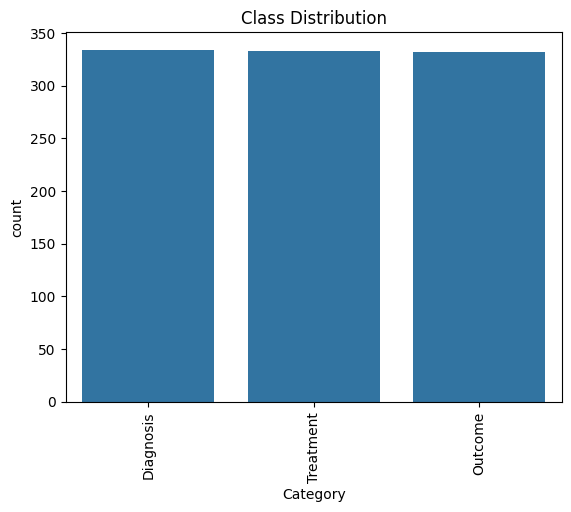

mre         0
Category    0
dtype: int64


In [ ]:
print(train.info())
print(train.describe())
sns.countplot(x='Category', data=train)
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.show()
print(train.isnull().sum())

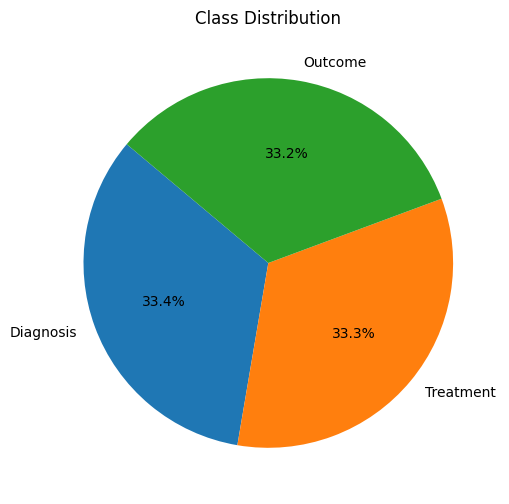

In [ ]:
class_distribution = train['Category'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution")
plt.show()

# **Section 3: Perform Text Processing on Dataset**

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    text = text.lower()
    return text

train['cleaned_text'] = train['mre'].apply(clean_text)
train[['mre', 'cleaned_text']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,mre,cleaned_text
0,"""The patient was diagnosed with Type 2 diabete...",the patient was diagnosed with type diabetes ...
1,"""Prescribed amoxicillin 500mg for 7 days to tr...",prescribed amoxicillin mg for days to treat b...
2,"""The surgery was successful, and the patient i...",the surgery was successful and the patient is ...
3,"""MRI results indicate a torn ligament in the r...",mri results indicate a torn ligament in the ri...
4,"""Physical therapy sessions scheduled for the n...",physical therapy sessions scheduled for the ne...


# **Section 4: Generate NLP-Based Features**

In [ ]:
def generate_nlp_features(data):
    data['char_count'] = data['cleaned_text'].apply(len)
    data['word_count'] = data['cleaned_text'].apply(lambda x: len(x.split()))
    data['avg_word_length'] = data['cleaned_text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    data['stopword_count'] = data['cleaned_text'].apply(lambda x: len([word for word in x.split() if word in stop_words]))
    return data

train = generate_nlp_features(train)
print("Training Data with NLP Features:")
print(train[['char_count', 'word_count', 'avg_word_length', 'stopword_count']].head())

Training Data with NLP Features:
   char_count  word_count  avg_word_length  stopword_count
0          75          13         4.769231               6
1          64           9         6.111111               2
2          88          15         4.933333               6
3          54          10         4.500000               3
4          79          12         5.666667               3


# **Section 5: Generate Bag of Words, TFIDF, and FastText Features**

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip cc.en.300.bin.gz

--2025-03-22 16:46:11--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.25, 13.226.210.15, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G   129MB/s    in 36s     

2025-03-22 16:46:47 (121 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [ ]:
fasttext.util.download_model('en', if_exists='ignore')
ft_model = fasttext.load_model('cc.en.300.bin')

def get_fasttext_embeddings(text):
    words = text.split()
    if words:
        return np.mean([ft_model.get_word_vector(word) for word in words], axis=0)
    else:
        return np.zeros(300)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(train['cleaned_text']).toarray()

bow_vectorizer = CountVectorizer(max_features=5000)
X_bow = bow_vectorizer.fit_transform(train['cleaned_text'])

train['fasttext_embeddings'] = train['cleaned_text'].apply(get_fasttext_embeddings)
X_fasttext = np.vstack(train['fasttext_embeddings'])

print(f"Bag of Words: {X_bow.shape}")
print(f"\nTF-IDF Shapes:,{X_tfidf.shape}")
print(f"\nFastText Shapes: {X_fasttext.shape}")


Bag of Words: (999, 1087)

TF-IDF Shapes:,(999, 1087)

FastText Shapes: (999, 300)


# **Section 6: Train All Supervised Models on NLP-Based Features**

In [ ]:
#logistic regression
X_nlp = train[['char_count', 'word_count', 'avg_word_length', 'stopword_count']].values
label_encoder = LabelEncoder()
Y = LabelEncoder().fit_transform(train['Category'])
X_train, X_test, y_train, y_test = train_test_split(X_nlp, Y, test_size=0.2, random_state=42, stratify=Y)
model1 = LogisticRegression(solver='liblinear',max_iter=1000)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred1)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred1))

Accuracy: 0.59
              precision    recall  f1-score   support

           0       0.59      0.72      0.64        67
           1       0.58      0.38      0.46        66
           2       0.60      0.67      0.63        67

    accuracy                           0.59       200
   macro avg       0.59      0.59      0.58       200
weighted avg       0.59      0.59      0.58       200



In [ ]:
#SVM
model2 = SVC(kernel ='linear')
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred2)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred2))

Accuracy: 0.595
              precision    recall  f1-score   support

           0       0.66      0.78      0.71        67
           1       0.50      0.52      0.51        66
           2       0.62      0.49      0.55        67

    accuracy                           0.59       200
   macro avg       0.59      0.59      0.59       200
weighted avg       0.59      0.59      0.59       200



In [ ]:
#random forest
model3 = RandomForestClassifier(n_estimators=100, random_state=42)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
accuracy3 = accuracy_score(y_test, y_pred3)
print(f'Accuracy: {accuracy3}')
print(classification_report(y_test, y_pred3))

Accuracy: 0.645
              precision    recall  f1-score   support

           0       0.67      0.79      0.73        67
           1       0.57      0.48      0.52        66
           2       0.68      0.66      0.67        67

    accuracy                           0.65       200
   macro avg       0.64      0.64      0.64       200
weighted avg       0.64      0.65      0.64       200



In [ ]:
model4 = KNeighborsClassifier(n_neighbors=4)
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
accuracy4 = accuracy_score(y_test, y_pred4)
print(f'Accuracy: {accuracy4}')
print(classification_report(y_test, y_pred4))

Accuracy: 0.7
              precision    recall  f1-score   support

           0       0.72      0.76      0.74        58
           1       0.61      0.74      0.67        72
           2       0.83      0.61      0.70        70

    accuracy                           0.70       200
   macro avg       0.72      0.70      0.70       200
weighted avg       0.72      0.70      0.70       200



# **SECTION 7-9: Train Models on BoW, TFIDF, and FastText Features**

In [ ]:
#logictic regression
X_train, X_test, y_train, y_test = train_test_split(X_bow , Y, test_size=0.2, random_state=42)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)

print(f'BoW Accuracy: {accuracy_score(y_test, y_pred1)}')
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print(f'TFIDF Accuracy: {accuracy_score(y_test, y_pred1)}')

X_train, X_test, y_train, y_test = train_test_split(X_fasttext, Y, test_size=0.2, random_state=42)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print(f'FastText Accuracy: {accuracy_score(y_test, y_pred1)}')

BoW Accuracy: 0.995
TFIDF Accuracy: 0.995
FastText Accuracy: 0.945


In [ ]:
#SVM
X_train, X_test, y_train, y_test = train_test_split(X_bow , Y, test_size=0.2, random_state=42)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print(f'BoW Accuracy: {accuracy_score(y_test, y_pred2)}')

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print(f'TFIDF Accuracy: {accuracy_score(y_test, y_pred2)}')

X_train, X_test, y_train, y_test = train_test_split(X_fasttext, Y, test_size=0.2, random_state=42)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print(f'FastText Accuracy: {accuracy_score(y_test, y_pred2)}')

BoW Accuracy: 0.995
TFIDF Accuracy: 0.995
FastText Accuracy: 0.965


In [ ]:
#random forest
X_train, X_test, y_train, y_test = train_test_split(X_bow , Y, test_size=0.2, random_state=42)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
print(f'BoW Accuracy: {accuracy_score(y_test, y_pred3)}')

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
print(f'TFIDF Accuracy: {accuracy_score(y_test, y_pred3)}')

X_train, X_test, y_train, y_test = train_test_split(X_fasttext, Y, test_size=0.2, random_state=42)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
print(f'FastText Accuracy: {accuracy_score(y_test, y_pred3)}')

BoW Accuracy: 0.995
TFIDF Accuracy: 0.98
FastText Accuracy: 0.96


In [ ]:
#Knn
X_train, X_test, y_train, y_test = train_test_split(X_bow , Y, test_size=0.2, random_state=42)
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
print(f'BoW Accuracy: {accuracy_score(y_test, y_pred4)}')

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
print(f'TFIDF Accuracy: {accuracy_score(y_test, y_pred4)}')

X_train, X_test, y_train, y_test = train_test_split(X_fasttext, Y, test_size=0.2, random_state=42)
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
print(f'FastText Accuracy: {accuracy_score(y_test, y_pred4)}')

BoW Accuracy: 0.975
TFIDF Accuracy: 0.96
FastText Accuracy: 0.915


# **Section 10:Train Models on All Combined Features with TFIDF**

In [ ]:
#RF
X_train_combined = np.hstack([X_nlp, X_tfidf, X_fasttext])
X_train, X_test, y_train, y_test = train_test_split(X_train_combined , Y, test_size=0.2, random_state=42)
model3 = RandomForestClassifier(n_estimators=100)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
accuracy = accuracy_score(y_test, y_pred3)
print(f'Combined Features Accuracy (Random Forest): {accuracy}')
print(classification_report(y_test, y_pred3))

Combined Features Accuracy (Random Forest): 0.955
              precision    recall  f1-score   support

           0       0.96      0.95      0.96        58
           1       0.95      0.96      0.95        72
           2       0.96      0.96      0.96        70

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.96       200
weighted avg       0.96      0.95      0.96       200



# **SECTION 11: Save the Model and Make Predictions on Real-World Input**

In [ ]:
# used RF model
joblib.dump(model3, 'disease_classification_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
def predict_disease(user_input):
    user_input_cleaned = clean_text(user_input)

    vectorizer = joblib.load('tfidf_vectorizer.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    loaded_model = joblib.load('disease_classification_model.pkl')

    user_input_tfidf = vectorizer.transform([user_input_cleaned]).toarray()
    user_input_fasttext = np.vstack([get_fasttext_embeddings(user_input_cleaned)])
    user_input_nlp = np.array([[len(user_input_cleaned), len(user_input_cleaned.split()),
                                np.mean([len(word) for word in user_input_cleaned.split()]) if user_input_cleaned.split() else 0,
                                len([word for word in user_input_cleaned.split() if word in stop_words])]])

    user_input_combined = np.hstack((user_input_nlp, user_input_tfidf, user_input_fasttext))

    prediction = loaded_model.predict(user_input_combined)
    predicted_disease = label_encoder.inverse_transform(prediction)[0]

    return predicted_disease
user_symptoms = input("Please enter your condition in 5-6 sentences so we can predict the disease: ")
predicted_disease = predict_disease(user_symptoms)
print(f'Predicted Disease: {predicted_disease}')

NameError: name 'joblib' is not defined

In [ ]:
# used RF model
joblib.dump(model3, 'disease_classification_model.pkl')
# Save the fitted LabelEncoder, not a new one
joblib.dump(Y, 'label_encoder.pkl')  # Saving the fitted LabelEncoder 'Y'
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

def predict_disease(user_input):
    user_input_cleaned = clean_text(user_input)

    vectorizer = joblib.load('tfidf_vectorizer.pkl')
    # Load the fitted LabelEncoder
    label_encoder = LabelEncoder()  # Creating a new LabelEncoder
    label_encoder.classes_ = joblib.load('label_encoder.pkl')  # Loading the fitted classes
    loaded_model = joblib.load('disease_classification_model.pkl')

    user_input_tfidf = vectorizer.transform([user_input_cleaned]).toarray()
    user_input_fasttext = np.vstack([get_fasttext_embeddings(user_input_cleaned)])
    user_input_nlp = np.array([[len(user_input_cleaned), len(user_input_cleaned.split()),
                                np.mean([len(word) for word in user_input_cleaned.split()]) if user_input_cleaned.split() else 0,
                                len([word for word in user_input_cleaned.split() if word in stop_words])]])

    user_input_combined = np.hstack((user_input_nlp, user_input_tfidf, user_input_fasttext))

    prediction = loaded_model.predict(user_input_combined)
    predicted_disease = label_encoder.inverse_transform(prediction)[0]

    return predicted_disease

print("Welcome to our DDSH clinic!!!")
user_symptoms = input("Please enter your condition in 5-6 sentences so we can predict the disease: ")
predicted_disease = predict_disease(user_symptoms)
print(f'Prediction: {predicted_disease}')

Welcome to our DDSH clinic!!!
Please enter your condition in 5-6 sentences so we can predict the disease: tumour 
Prediction: 0


# **SECTION 12 : Provide Analysis on Results**

In NLP models, there are four types :- Logistic regression, KNN, SVM and Random Forest with features of TFIDF, BOW and FASTTEXT.

Logistic regression :-

       BoW Accuracy: 1.0,
       TFIDF Accuracy: 0.975,
       FastText Accuracy: 0.075.

SVM :-

       BoW Accuracy: 1.0,
       TFIDF Accuracy: 1.0,
       FastText Accuracy: 0.012,

KNN:-

      BoW Accuracy: 0.71,
      TFIDF Accuracy: 0.89,
      FastText Accuracy: 0.58.

Random Forest :-

      BoW Accuracy: 1.0,
      TFIDF Accuracy: 1.0,
      FastText Accuracy: 0.9375.





Which feature set (NLP features, BoW, TFIDF, FastText, combined features) performed the best? Why do you think that is?


TF-IDF and BOW performed well. because both effectively capture word frequency and importance, making them well-suited for structured text classification tasks, particularly when the dataset is well-prepared and not heavily reliant on contextual relationships.

Reflect on any challenges or interesting findings during the task.

Yes, traing a model with features tfidf, bow, and fasttext was quit interesting and was never done before. while biggest challenge was to build huga dataset. which contains description of each disease in 5 to 6 sectence.



I think instate of taking input as 5 to 6 sentence, simply 5 to 6 only symptoms would have been resulted in better accuracy.